# Análisis de fuga de empleados

# 1- Identificación del problema

### Descripción del requerimiento

Durante el último año se ha estado produciendo una marcha constante de capital humano. Esto está generando varios problemas para la empresa:

* Fuga de talento y experiencia
* Presión sobre RRHH para reemplazar empleados
* Incremento de los costes asociados al reemplazo

En este contexto, el Director de RRHH ha contactado con el equipo de Data Science para ver si analíticamente le podemos ayudar a:

* Perfilar, concretar y cuantificar el problema
* Identificar patrones o perfiles prioritarios sobre los que actuar
* Definir una batería de acciones de fidelización tanto a nivel grupo de riesgo como a nivel empleado individual
* Generar activos analíticos de apoyo que permitan al departamento de RRHH abordar este problema de forma más rápida y eficaz


#### Carga de datos

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
df = pd.read_csv('AbandonoEmpleados.csv', sep = ';', index_col= 'id', na_values='#N/D')

In [10]:
df.head()

,edad,abandono,viajes,departamento,distancia_casa,educacion,carrera,empleados,satisfaccion_entorno,sexo,...,satisfaccion_companeros,horas_quincena,nivel_acciones,anos_experiencia,num_formaciones_ult_ano,conciliacion,anos_compania,anos_en_puesto,anos_desde_ult_promocion,anos_con_manager_actual
id,,,,,,,,,,,,,,,,,,,,,
1,41,Yes,Travel_Rarely,Sales,1,Universitaria,Life Sciences,1,Media,3.0,...,Baja,80,0,8,0,NaN,6,NaN,0,5
2,49,No,Travel_Frequently,Research & Development,8,Secundaria,Life Sciences,1,Alta,2.0,...,Muy_Alta,80,1,10,3,NaN,10,NaN,1,7
4,37,Yes,Travel_Rarely,Research & Development,2,Secundaria,Other,1,Muy_Alta,2.0,...,Media,80,0,7,3,NaN,0,2.0,0,0
5,33,No,Travel_Frequently,Research & Development,3,Universitaria,Life Sciences,1,Muy_Alta,3.0,...,Alta,80,0,8,3,NaN,8,3.0,3,0
7,27,No,Travel_Rarely,Research & Development,2,Universitaria,Medical,1,Baja,3.0,...,Muy_Alta,80,1,6,3,NaN,2,NaN,2,2


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1470 entries, 1 to 2068
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   edad                      1470 non-null   int64  
 1   abandono                  1470 non-null   object 
 2   viajes                    1470 non-null   object 
 3   departamento              1470 non-null   object 
 4   distancia_casa            1470 non-null   int64  
 5   educacion                 1369 non-null   object 
 6   carrera                   1470 non-null   object 
 7   empleados                 1470 non-null   int64  
 8   satisfaccion_entorno      1470 non-null   object 
 9   sexo                      1271 non-null   float64
 10  implicacion               1452 non-null   object 
 11  nivel_laboral             1470 non-null   int64  
 12  puesto                    1470 non-null   object 
 13  satisfaccion_trabajo      1394 non-null   object 
 14  estado_c

#### ANÁLISIS DE NULOS

In [12]:
df.isna().sum().sort_values(ascending = False)

anos_en_puesto              1238
conciliacion                1011
sexo                         199
educacion                    101
satisfaccion_trabajo          76
implicacion                   18
edad                           0
nivel_acciones                 0
evaluacion                     0
satisfaccion_companeros        0
horas_quincena                 0
anos_experiencia               0
horas_extra                    0
num_formaciones_ult_ano        0
anos_compania                  0
anos_desde_ult_promocion       0
incremento_salario_porc        0
salario_mes                    0
mayor_edad                     0
num_empresas_anteriores        0
abandono                       0
estado_civil                   0
puesto                         0
nivel_laboral                  0
satisfaccion_entorno           0
empleados                      0
carrera                        0
distancia_casa                 0
departamento                   0
viajes                         0
anos_con_m

Conclusiones:

* anos_en_puesto y conciliacion tienen demasiados nulos --> eliminar Variables
* sexo, educacion, satisfaccion_trabajo e implicacion --> imputarlos tras EDA

In [16]:
df.drop(columns = ['anos_en_puesto','conciliacion'], inplace = True)
# eliminamos estas variables que tienen demasiados nulos

#### EDA VARIABLES CATEGÓRICAS (Analisis Exploratorio de Datos)

In [17]:
def graficos_eda_categoricos(cat):
    
    #Calculamos el número de filas que necesitamos
    from math import ceil
    filas = ceil(cat.shape[1] / 2)

    #Definimos el gráfico
    f, ax = plt.subplots(nrows = filas, ncols = 2, figsize = (16, filas * 6))

    #Aplanamos para iterar por el gráfico como si fuera de 1 dimensión en lugar de 2
    ax = ax.flat 

    #Creamos el bucle que va añadiendo gráficos
    for cada, variable in enumerate(cat):
        cat[variable].value_counts().plot.barh(ax = ax[cada])
        ax[cada].set_title(variable, fontsize = 12, fontweight = "bold")
        ax[cada].tick_params(labelsize = 12)

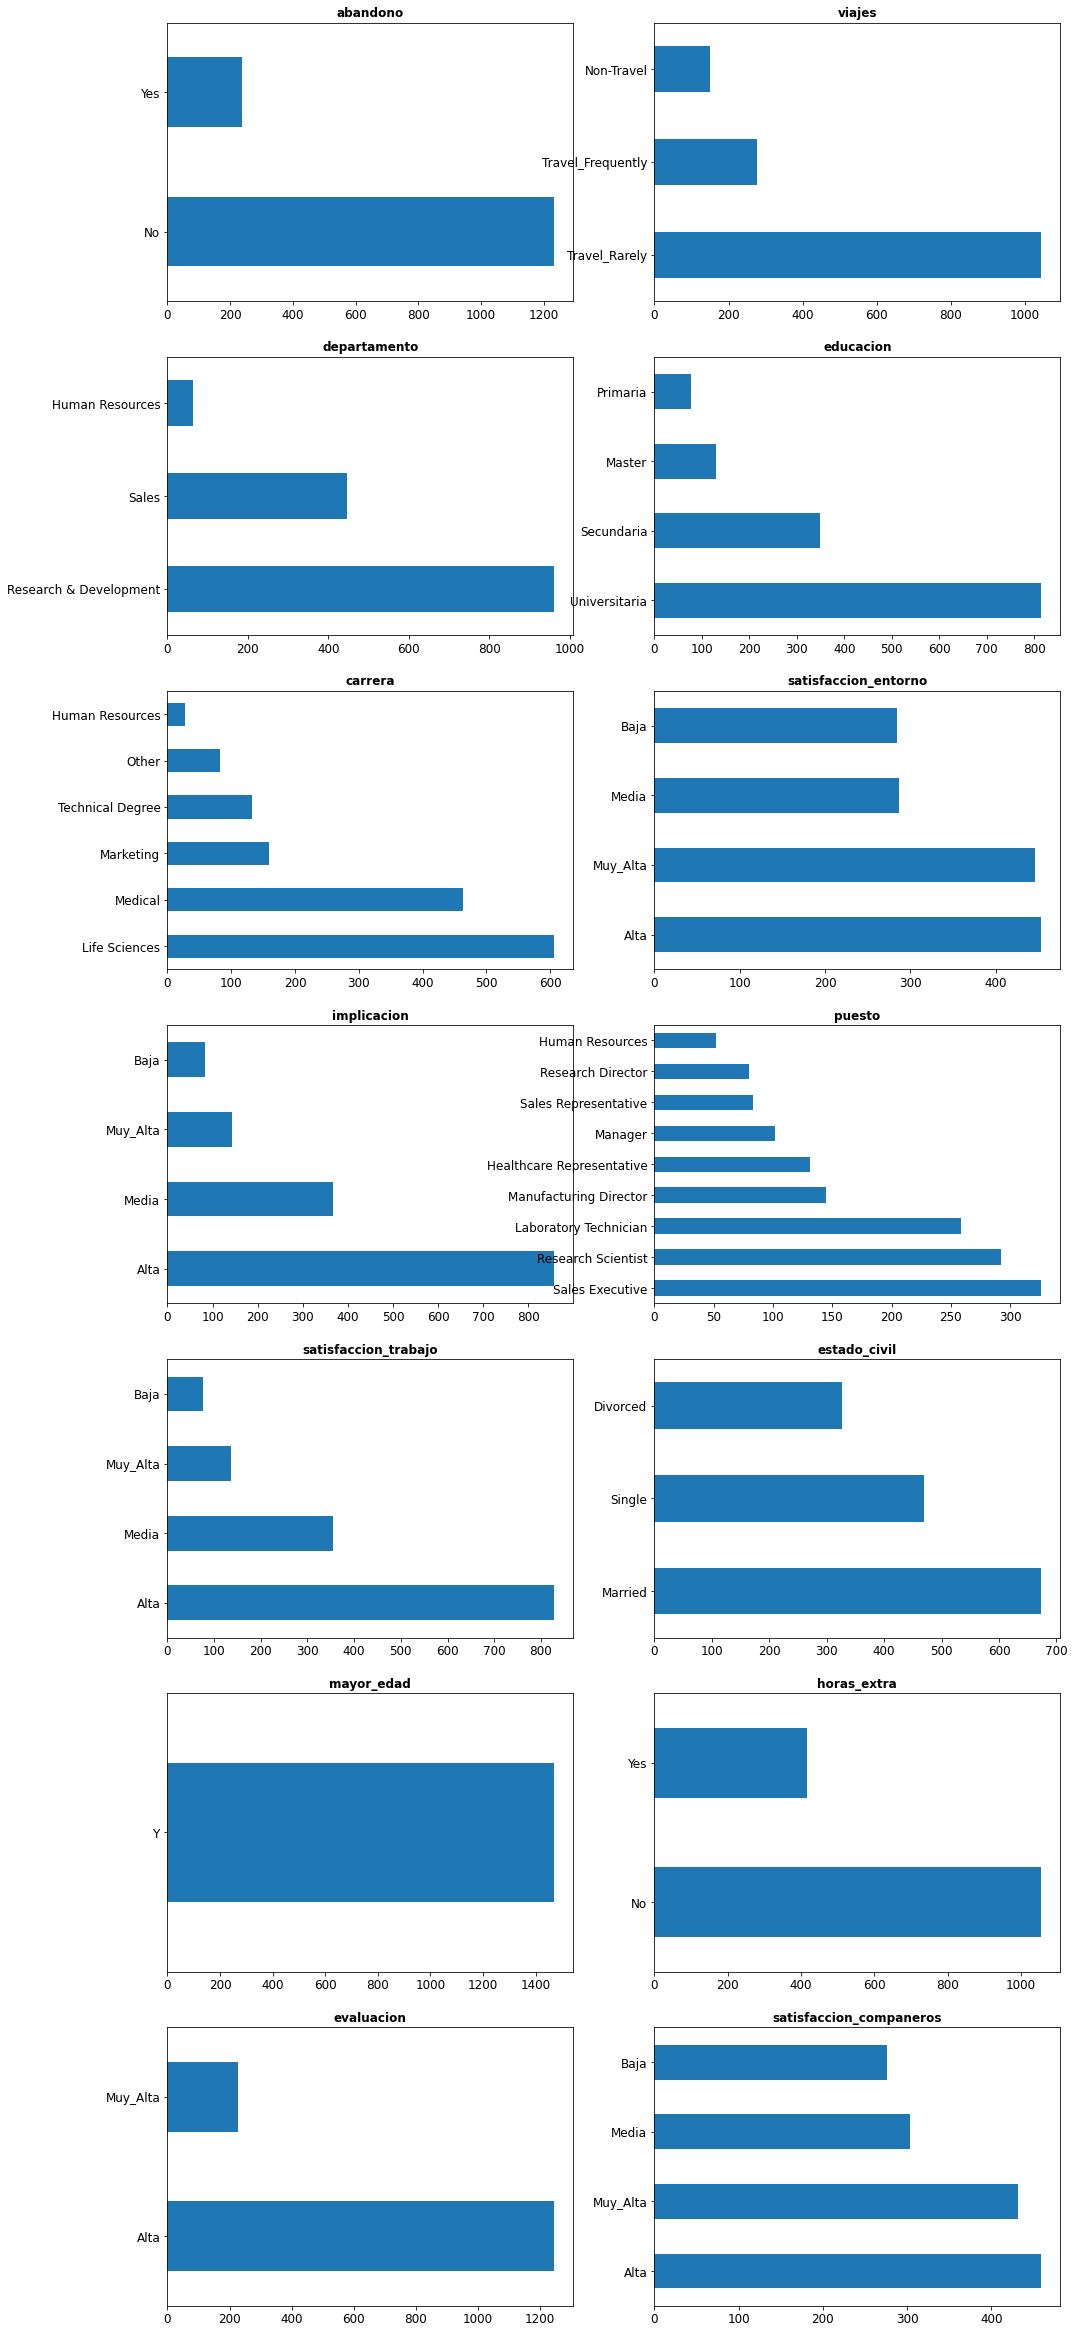

In [18]:
graficos_eda_categoricos(df.select_dtypes('O'))

Conclusiones:

* mayor_edad solo tiene un valor --> eliminarla
* Sobre las imputaciones pendientes de variables categóricas:
  * educacion: imputar por 'Universitaria'
  * satisfaccion_trabajo: imputar por 'Alta'
  * implicacion: imputar por 'Alta'

In [20]:
df.drop(columns = 'mayor_edad', inplace = True)

df['educacion'] = df['educacion'].fillna('Universitaria')

df['satisfaccion_trabajo'] = df['satisfaccion_trabajo'].fillna('Alta')

df['implicacion'] = df['implicacion'].fillna('Alta')

#### EDA VARIABLES NUMÉRICAS

In [21]:
def estadisticos_cont(num):
    #Calculamos describe
    estadisticos = num.describe().T
    #Añadimos la mediana
    estadisticos['median'] = num.median()
    #Reordenamos para que la mediana esté al lado de la media
    estadisticos = estadisticos.iloc[:,[0,1,8,2,3,4,5,6,7]]
    #Lo devolvemos
    return(estadisticos)

In [22]:
estadisticos_cont(df.select_dtypes('number'))

,count,mean,median,std,min,25%,50%,75%,max
edad,1470.0,36.923810,36.0,9.135373,18.0,30.0,36.0,43.0,60.0
distancia_casa,1470.0,9.192517,7.0,8.106864,1.0,2.0,7.0,14.0,29.0
empleados,1470.0,1.000000,1.0,0.000000,1.0,1.0,1.0,1.0,1.0
sexo,1271.0,2.727773,3.0,0.720788,1.0,2.0,3.0,3.0,4.0
nivel_laboral,1470.0,2.063946,2.0,1.106940,1.0,1.0,2.0,3.0,5.0
salario_mes,1470.0,6502.931293,4919.0,4707.956783,1009.0,2911.0,4919.0,8379.0,19999.0
num_empresas_anteriores,1470.0,2.693197,2.0,2.498009,0.0,1.0,2.0,4.0,9.0
incremento_salario_porc,1470.0,15.209524,14.0,3.659938,11.0,12.0,14.0,18.0,25.0
horas_quincena,1470.0,80.000000,80.0,0.000000,80.0,80.0,80.0,80.0,80.0
nivel_acciones,1470.0,0.793878,1.0,0.852077,0.0,0.0,1.0,1.0,3.0


Conclusiones:

* Empleados solo tiene un valor --> Eliminarla
* Sexo tiene 4 valores --> Eliminarla
* Horas quincena solo tiene una valor --> Eliminarla
* De los nulos pendientes de imputación que sean numéricas solo está el sexo, pero como la vamos a eliminar ya no hay que imputar nada


In [23]:
df.drop(columns = ['empleados','sexo','horas_quincena'], inplace = True)

## Puntos Clave

### Cuantificación del problema: ¿Cual es la tasa de abandono?

In [24]:
df.abandono.value_counts(normalize = True) * 100

No     83.877551
Yes    16.122449
Name: abandono, dtype: float64

### ¿Hay un perfil tipo de empleado que deja la empresa?

In [25]:
# Transformar abandono a numérica
df['abandono'] = df.abandono.map({'No':0, 'Yes':1})

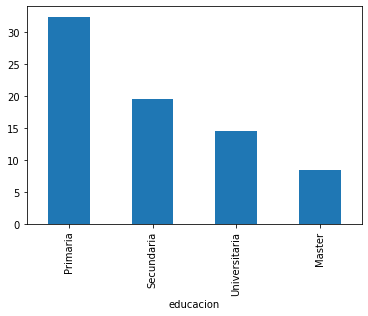

In [26]:
# Analisis por educación
temp = df.groupby('educacion').abandono.mean().sort_values(ascending = False) * 100
temp.plot.bar();

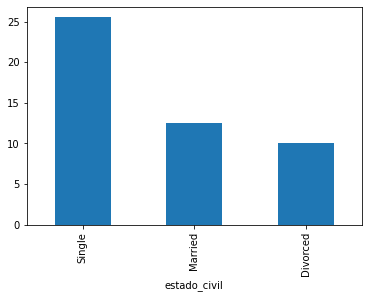

In [27]:
# Analisis por estado civil
temp = df.groupby('estado_civil').abandono.mean().sort_values(ascending = False) * 100
temp.plot.bar();

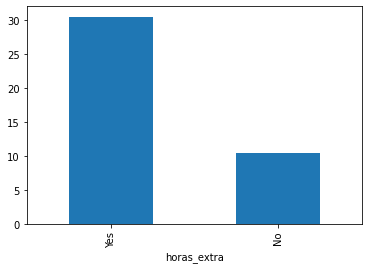

In [28]:
# Analisis por horas extras
temp = df.groupby('horas_extra').abandono.mean().sort_values(ascending = False) * 100
temp.plot.bar();

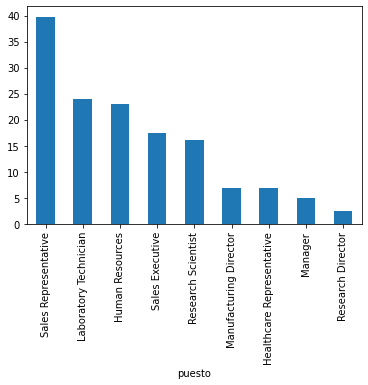

In [29]:
# Analisis por puesto
temp = df.groupby('puesto').abandono.mean().sort_values(ascending = False) * 100
temp.plot.bar();

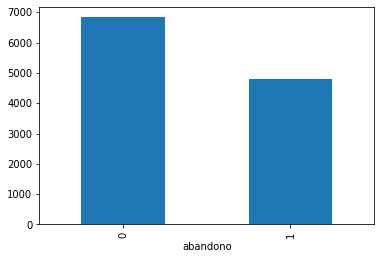

In [30]:
temp = df.groupby('abandono').salario_mes.mean()
temp.plot.bar();

en el anterior gráfico vemos que los que tienen "abandono = yes" tienen un salario medio más bajo

### Conclusiones:

El perfil medio del empleado que deja la empresa es:

* Bajo nivel educativo
* Soltero
* Trabaja en ventas
* Bajo salario
* Alta carga de horas extras

### Exportación de la tabla procesada

In [36]:
df.to_csv("AbandonoProcesado.csv")